## Program Flow

1. モジュールインポート

# モジュールインポート

In [1]:
# scikitlearnのアルゴリズムのロード
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.model_selection import StratifiedKFold

#import autosklearn.classification

# scikit learnのテストデータの読み込み
from sklearn.model_selection import train_test_split

# scikit learnの精度測定ツールの読み込み
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 

#トレーニングデータと正解ラベルに分割
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# pandas(pd) とNumpy(np)のモジュール
import numpy as np
import pandas as pd
import sys,os,random
import warnings
warnings.filterwarnings('ignore')

from collections import defaultdict
from matplotlib import pyplot as plt

# 変数定義

In [2]:
# 0.97 は5000万ぐらい儲かった
# pram_traing_rate=0.97   #トレーニングデータとテストデータの比率

pram_traing_rate=0.9  #トレーニングデータとテストデータの比率

# 前処理済みファイルのロード

In [2]:
# 乱数のシード固定
np.random.seed(0)
random.seed(0)
# データフレームの表示件数の設定
pd.set_option('display.max_columns', 100)

# データロード
#df = pd.read_csv('data/stock_preprocessing_2values.csv', index_col=None)
df = pd.read_pickle('data/stock_preprocessing.pkl')


y_loc_s=df.columns.get_loc('label_up')
y_loc_e=df.columns.get_loc('label_down')
df.tail(3)


# 前後のデータのカット
df3=df.loc[30:(len(df)-30)]
df2_num=df3.as_matrix()   #numpyへ変換

fx_len=len(df3)

## データの分割


In [4]:
train, test = train_test_split(df3, train_size=pram_traing_rate,shuffle=False)

print("訓練データ  :{}〜{}".format(train.head(1)['Date'].values[0],train.tail(1)['Date'].values[0]),train.shape)
print("テストデータ:{}〜{}".format(test.head(1)['Date'].values[0],test.tail(1)['Date'].values[0]),test.shape)



訓練データ  :2000-02-17T00:00:00.000000000〜2018-04-09T00:00:00.000000000 (4298, 45)
テストデータ:2018-04-10T00:00:00.000000000〜2020-04-20T00:00:00.000000000 (478, 45)


In [5]:

#トレーニングデータと正解ラベルに分割
# 説明変数
trainX,testX=train.iloc[:,3:y_loc_s],test.iloc[:,3:y_loc_s]
# 正解データ
trainY,testY=train.iloc[:,y_loc_s:y_loc_e+1],test.iloc[:,y_loc_s:y_loc_e+1]

#display(testX)
#Numpy形式に変換
trainX,testX=trainX.as_matrix(),testX.as_matrix()
trainY,testY=trainY.as_matrix(),testY.as_matrix()

#データサンプル数の確認
print("トレーニングデータ",trainX.shape)
print("トレーニングデータ",trainY.shape)
print("　 　 テストデータ",testX.shape)
print("　 　 テストデータ",testY.shape)

トレーニングデータ (4298, 39)
トレーニングデータ (4298, 2)
　 　 テストデータ (478, 39)
　 　 テストデータ (478, 2)


# sckit-learnの準備


In [6]:
# ワンホットからカテゴリ変数へ
testY2 =np.argmax(testY,axis=1)
trainY2=np.argmax(trainY,axis=1)

In [7]:
names = [
       "AdaBoostClassifier"
        ]

# Initializing Classifiers
classifiers = [
    AdaBoostClassifier()
]

In [8]:
columns=['name','accuracy']
df_acc=pd.DataFrame(data=None,columns=columns)

for classifier, name in zip(classifiers, names):
    
    #　該当分類器にて、学習
    classifier.fit(trainX ,trainY2)
 
    #　分類器の正答率を求める
    pre=classifier.predict(testX)
    ac_score=accuracy_score(testY2,pre)
    print('分類器:{:} , 精度:{:.2%}'.format(name,ac_score))

    # 結果をデータフレームに入れる
    s=pd.Series(data=[name,ac_score],index=columns)
    df_acc=df_acc.append(s,ignore_index=True)

分類器:AdaBoostClassifier , 精度:49.58%


In [9]:
classifier=classifiers[df_acc[df_acc['accuracy']==df_acc['accuracy'].max()].index[0]]
classifier.fit(trainX ,trainY2)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [10]:

def permuted(df):
    """特定のカラムをシャッフルしたデータフレームを返す"""
    for column_name in df.columns:
        permuted_df = df.copy()
        permuted_df[column_name] = np.random.permutation(permuted_df[column_name])
        yield column_name, permuted_df


def pimp(clf, X, y, cv=None, eval_func=accuracy_score):
    """PIMP (Permutation IMPortance) を計算する"""
    base_scores = []
    permuted_scores = defaultdict(list)

    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in cv.split(X, y):
        # 学習用データと検証用データに分割する
        X_train, y_train = X.iloc[train_index], y.iloc[train_index]
        X_test, y_test = X.iloc[test_index], y.iloc[test_index]

        # 学習用データでモデルを学習する
        clf.fit(X_train, y_train)

        # まずは何もシャッフルしていないときのスコアを計算する
        y_pred_base = clf.predict(X_test)
        base_score = eval_func(y_test, y_pred_base)
        base_scores.append(base_score)

        # 特定のカラムをシャッフルした状態で推論したときのスコアを計算する
        permuted_X_test_gen = permuted(X_test)
        for column_name, permuted_X_test in permuted_X_test_gen:
            y_pred_permuted = clf.predict(permuted_X_test)
            permuted_score = eval_func(y_test, y_pred_permuted)
            permuted_scores[column_name].append(permuted_score)

    # 基本のスコアとシャッフルしたときのスコアを返す
    np_base_score = np.array(base_scores)
    dict_permuted_score = {name: np.array(scores) for name, scores in permuted_scores.items()}
    return np_base_score, dict_permuted_score


def score_difference_statistics(base, permuted):
    """シャッフルしたときのスコアに関する統計量 (平均・標準偏差) を返す"""
    mean_base_score = base.mean()
    for column_name, scores in permuted.items():
        score_differences = scores - mean_base_score
        yield column_name, score_differences.mean(), score_differences.std()


# 重要度の分析

In [11]:

# Iris データセットを読み込む
X=df3.iloc[:,3:y_loc_s]
y=pd.Series(np.argmax(df3.iloc[:,y_loc_s:y_loc_e+1].as_matrix(),axis=1))

# 計測に使うモデルを用意する
clf = RandomForestClassifier(n_estimators=100)

# Permutation Importance を計測する
base_score, permuted_scores = pimp(clf, X, y)

# 計測結果から統計量を計算する
diff_stats = list(score_difference_statistics(base_score, permuted_scores))

# カラム名、ベーススコアとの差、95% 信頼区間を取り出す
sorted_diff_stats = sorted(diff_stats, key=lambda x: x[1])
column_names = [name for name, _, _ in sorted_diff_stats]
diff_means = [diff_mean for _, diff_mean, _ in sorted_diff_stats]
diff_stds_95 = [diff_std * 1.96 for _, _, diff_std in sorted_diff_stats]

# どの説明変数が聞いているのか

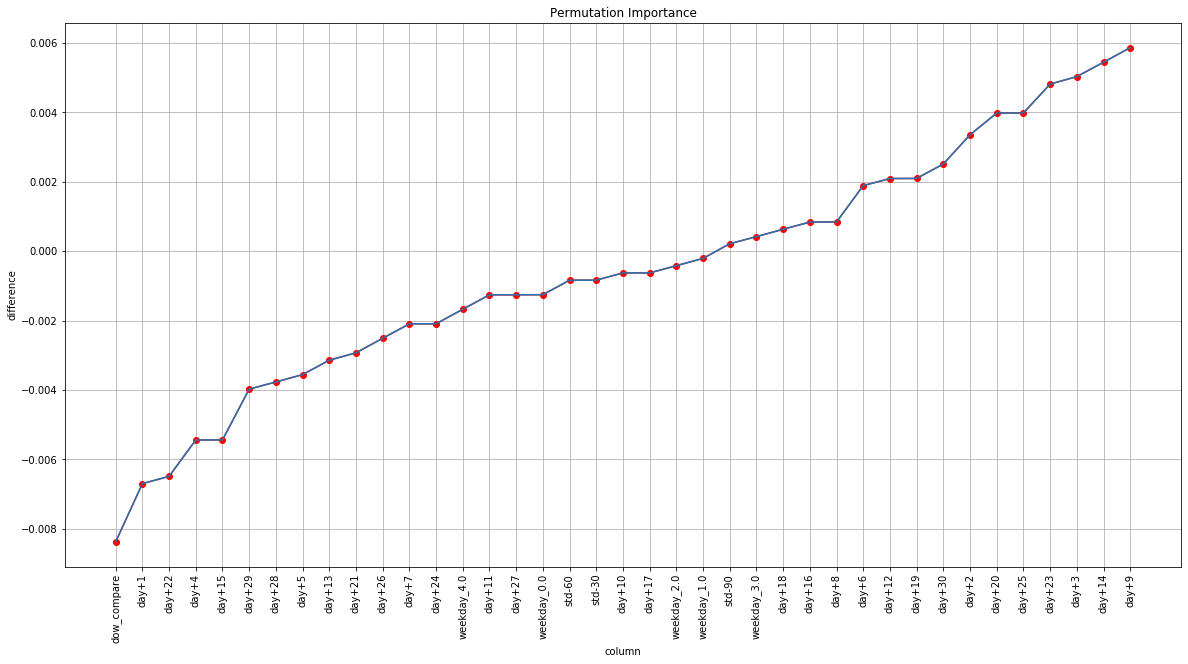

In [12]:
# グラフにプロットする

plt.figure(figsize=(20,10))

plt.plot(column_names, diff_means, marker='o', color='r')
plt.errorbar(column_names, 
             diff_means,
             #yerr=diff_stds_95,
             ecolor='g',
             #rotation=90,
             capsize=4)

plt.xticks(column_names,rotation=90)

plt.title('Permutation Importance')
plt.grid()
plt.xlabel('column')
plt.ylabel('difference')
plt.show()

In [27]:

pd.DataFrame(diff_means,index=column_names)


,0
dow_compare,-0.008375
day+1,-0.006698
day+22,-0.006488
day+4,-0.005441
day+15,-0.005439
day+29,-0.003976
day+28,-0.003769
day+5,-0.003557
day+13,-0.003141
day+21,-0.002930


In [18]:
diff_means

[-0.00837542991084137,
 -0.006698284737891236,
 -0.006488203465574227,
 -0.005440644921027793,
 -0.0054393305439330185,
 -0.003975552586036879,
 -0.003768757256456834,
 -0.003556923481346741,
 -0.0031411421936953345,
 -0.0029301846699817725,
 -0.0025106793138951035,
 -0.002095117089092802,
 -0.002092488334903242,
 -0.0016742973559113583,
 -0.0012587351311090789,
 -0.0012576398168634207,
 -0.001255230125522966,
 -0.0008370391465311155,
 -0.0008355057065871808,
 -0.0006267388113649242,
 -0.0006267388113649242,
 -0.00041862910469010474,
 -0.00020898595807131715,
 0.00021358627790317718,
 0.00041862910469017136,
 0.0006304628798002643,
 0.0008376963350785859,
 0.0008403250892681568,
 0.0018881026966637293,
 0.0020924883349033307,
 0.0020948980262437524,
 0.0025119936909899997,
 0.003351880654559858,
 0.0039801529058687505,
 0.003980591031566993,
 0.00481412517251204,
 0.00502880676466082,
 0.005443273675217475,
 0.0058632171570023985]